## Exercise 1

您为什么要使用tf.data API？

**答案**：

获取大型数据集并对其进行高效预处理可能是一项复杂的工程挑战。 数据 API 使它变得相当简单。 它提供了许多功能，包括从各种来源（如文本或二进制文件）加载数据、从多个来源并行读取数据、转换数据、交错记录、打乱数据、批处理和预取数据。

## Exercise 2

将一个大的数据集分割成多个文件的好处是什么？

**答案**：

将大型数据集拆分为多个文件，可以在使用混洗缓冲区将其混洗到更精细的水平之前，先对其进行粗略的洗牌。 它还可以处理单台机器无法容纳的庞大数据集。 操作数以千计的小文件也比操作一个大文件更简单； 例如，将数据拆分为多个子集会更容易。 最后，如果数据被拆分到分布在多个服务器上的多个文件中，则可以同时从不同的服务器下载多个文件，从而提高带宽使用率。

## Exercise 3

在训练期间，如何判断输入pipeline是瓶颈？你能做些什么来解决它呢？

**答案**：

您可以使用 TensorBoard 可视化分析数据：如果 GPU 没有得到充分利用，那么您的输入管道很可能成为瓶颈。 

您可以通过确保它在多个线程中并行读取和预处理数据并确保它预取几个批次来修复它。 如果这不足以让您的 GPU 在训练期间达到 100% 使用率，请确保您的预处理代码已优化。 您还可以尝试将数据集保存到多个 TFRecord 文件中，并在必要时提前执行一些预处理，这样就不需要在训练期间即时完成（TF Transform 可以帮助实现这一点）。 如有必要，请使用具有更多 CPU 和 RAM 的机器，并确保 GPU 带宽足够大。

## Exercise 4

是否可以将任何二进制数据保存到TFRecord文件，还是只保存序列化的协议缓冲区？

**答案**：

TFRecord 文件由一系列任意二进制记录组成：您可以在每条记录中存储您想要的任何二进制数据。 但是，实际上大多数 TFRecord 文件都包含序列化协议缓冲区序列。 这使得受益于协议缓冲区的优势成为可能，例如它们可以跨多种平台和语言轻松读取，并且它们的定义可以在以后以向后兼容的方式更新。

## Exercise 5

为什么要将所有数据转换为 Example protobuf 格式？为什么不使用你自己的 protobuf 定义呢？

**答案**：

Example protobuf 格式的优点是 TensorFlow 提供了一些操作来解析它（tf.io.parse\*example() 函数），而您无需定义自己的格式。 它足够灵活，可以表示大多数数据集中的实例。 

但是，如果它不涵盖您的用例，您可以定义自己的协议缓冲区，使用 protoc 编译它（设置 --descriptor_set_out 和 --include_imports 参数以导出 protobuf 描述符），并使用 tf.io.decode_proto( ) 函数来解析序列化的 protobuf（有关示例，请参见笔记本的“自定义 protobuf”部分）。 它更复杂，需要将描述符与模型一起部署，但可以做到。

## Exercise 6

使用 TFRecords 时，什么时候激活压缩？为什么不系统地这样做呢？

**答案**：

使用 TFRecord 时，如果训练脚本需要下载 TFRecord 文件，您通常会希望激活压缩，因为压缩会使文件变小，从而减少下载时间。 但是，如果文件与训练脚本位于同一台机器上，通常最好关闭压缩，以避免浪费 CPU 进行解压缩。

## Exercise 7

数据可以在写入数据文件时直接进行预处理，或者在 tf.data pipeline 中进行，或在模型中的预处理层中进行。你能列出每种选择的一些优缺点吗？

**答案**：

让我们看看每个预处理选项的优缺点：

1. 如果您在创建数据文件时对数据进行预处理，训练脚本将运行得更快，因为它不必即时执行预处理。 在某些情况下，预处理后的数据也会比原始数据小很多，这样可以节省一些空间并加快下载速度。 将预处理后的数据具体化也可能会有帮助，例如检查它或将其存档。 但是，这种方法有一些缺点。 首先，如果您需要为每个变体生成预处理数据集，那么尝试各种预处理逻辑并不容易。 其次，如果要进行数据扩充，则必须具体化数据集的许多变体，这将占用大量磁盘空间并花费大量时间来生成。 最后，经过训练的模型需要预处理数据，因此您必须在应用程序调用模型之前在应用程序中添加预处理代码。 在这种情况下，存在代码重复和预处理不匹配的风险。
2. 如果使用 tf.data pipeline 对数据进行预处理，则调整预处理逻辑和应用数据扩充会容易得多。 此外，tf.data 可以轻松构建高效的预处理管道（例如，使用多线程和预取）。 但是，以这种方式预处理数据会减慢训练速度。 此外，如果在创建数据文件时对数据进行了预处理，则每个训练实例将在每个时期预处理一次，而不是仅预处理一次。 好吧，除非数据集适合 RAM，并且您可以使用数据集的 cache() 方法缓存它。 最后，经过训练的模型仍将需要预处理数据。 但是，如果您在 tf.data 管道中使用预处理层来处理预处理步骤，那么您可以在最终模型中重复使用这些层（在训练后添加它们），以避免代码重复和预处理不匹配。
3. 如果将预处理层添加到模型中，则只需为训练和推理编写一次预处理代码。 如果您的模型需要部署到许多不同的平台，您将不需要多次编写预处理代码。 另外，您不会冒为模型使用错误预处理逻辑的风险，因为它将成为模型的一部分。 不利的一面是，在训练期间即时预处理数据会减慢速度，并且每个实例每个时期都会预处理一次。

## Exercise 8

列举几种编码分类整数特征的常见方法。关于文本呢？

**答案**：

让我们看看如何对分类文本特征和文本进行编码：

1. 要对具有自然顺序的分类特征进行编码，例如电影评级（例如，“差”、“一般”、“好”），最简单的选择是使用序号编码：按自然顺序对类别进行排序并映射 每个类别与其排名（例如，“坏”映射到 0，“平均”映射到 1，“好”映射到 2）。 然而，大多数分类特征都没有这样的自然顺序。 例如，职业或国家没有自然秩序。 在这种情况下，您可以使用 one-hot encoding，如果类别很多，则可以使用 embeddings。 使用 Keras，StringLookup 层可用于顺序编码（使用默认的 output_mode="int"），或独热编码（使用 output_mode="one_hot"）。 如果您想将多个分类文本特征一起编码，它还可以执行多热编码（使用 output_mode="multi_hot"），假设它们共享相同的类别并且哪个特征贡献哪个类别并不重要。 对于可训练的嵌入，您必须首先使用 StringLookup 层生成序号编码，然后使用嵌入层。
2. 对于文本，TextVectorization 层易于使用，可以很好地完成简单的任务，或者您可以使用 TF Text 来实现更高级的功能。 但是，您通常会希望使用预训练语言模型，您可以使用 TF Hub 或 Hugging Face 的 Transformers 库等工具获得这些模型。 最后两个选项将在第 16 章中讨论。

## Exercise 9

加载 Fashion MNIST 数据集（在第 10 章中介绍）； 将其拆分为训练集、验证集和测试集； 洗牌训练集； 并将每个数据集保存到多个 TFRecord 文件中。 每条记录应该是一个序列化的 Example protobuf，具有两个特征：序列化图像（使用 tf.io.serialize_tensor() 序列化每个图像）和标签。然后使用 tf.data 为每个集合创建一个高效的数据集。 最后，使用 Keras 模型训练这些数据集，包括一个预处理层来标准化每个输入特征。 尝试使输入管道尽可能高效，使用 TensorBoard 可视化分析数据。

**答案**：

In [6]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
from time import strftime
import tensorboard
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [3]:
tf.random.set_seed(42)

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(len(X_train), seed=42)

valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [7]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))

In [8]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

In [9]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [10]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

In [11]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    #image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [12]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)

valid_set = mnist_dataset(valid_filepaths)

test_set = mnist_dataset(test_filepaths)

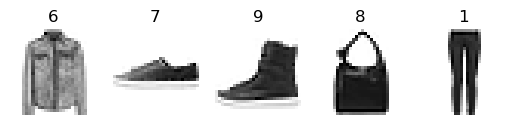

In [13]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [14]:
tf.random.set_seed(42)

standardization = tf.keras.layers.Normalization(input_shape=[28, 28])

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = tf.keras.Sequential([
    standardization,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [15]:
from datetime import datetime

logs = Path() / "my_logs" / "run_" / datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=5, validation_data=valid_set,
          callbacks=[tensorboard_cb])

Epoch 1/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4464 - accuracy: 0.8400 - val_loss: 0.3590 - val_accuracy: 0.8698
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3330 - accuracy: 0.8783 - val_loss: 0.3364 - val_accuracy: 0.8784
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2969 - accuracy: 0.8897 - val_loss: 0.3215 - val_accuracy: 0.8836
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2715 - accuracy: 0.8983 - val_loss: 0.3219 - val_accuracy: 0.8858
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2528 - accuracy: 0.9052 - val_loss: 0.3370 - val_accuracy: 0.8798


In [16]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

## Exercise 10

在本练习中，您将下载一个数据集，分割它，创建一个tf.data.Dataset，以有效地加载和预处理，然后构建并训练包含嵌入层的二分类模型：

1. 下载大型电影评论数据集，其中包含来自互联网电影数据库 (IMDb) 的 50,000 条电影评论。 数据被组织在两个目录中，train 和 test，每个目录包含一个包含 12,500 个正面评论的 pos 子目录和一个包含 12,500 个负面评论的 neg 子目录。 每条评论都存储在一个单独的文本文件中。 还有其他文件和文件夹（包括预处理的词袋版本），但我们将在本练习中忽略它们。
2. 将测试集拆分为验证集（15000）和测试集（10000）。
3. 使用tf.data为每个数据集创建一个有效的数据集。
4. 创建一个二分类模型，使用文本向量化层来对每个评论进行预处理。
5. 添加一个嵌入层，并计算每个评价的平均嵌入，再乘以单词数的平方根（见第16章）。这个重新缩放的平均嵌入可以传递到模型的其余部分。
6. 训练模型，看看你能得到什么样的准确性。试着优化你的pipeline，使训练尽可能快。
7. 使用TFDS可以更容易地加载相同的数据集：tfds.load（“imdb_reviews”）。

**答案**：

In [17]:
from pathlib import Path

root = "https://ai.stanford.edu/~amaas/data/sentiment/"
filename = "aclImdb_v1.tar.gz"

filepath = tf.keras.utils.get_file(filename, root + filename, extract=True,
                                   cache_dir=".")

path = Path(filepath).with_name("aclImdb")

path

84125825/84125825 [==============================] - 15s 0us/step


WindowsPath('datasets/aclImdb')

In [18]:
# view the structure of the aclImdb directory

def tree(path, level=0, indent=4, max_files=3):
    if level == 0:
        print(f"{path}/")
        level += 1
    sub_paths = sorted(path.iterdir())
    sub_dirs = [sub_path for sub_path in sub_paths if sub_path.is_dir()]
    filepaths = [sub_path for sub_path in sub_paths if not sub_path in sub_dirs]
    indent_str = " " * indent * level
    for sub_dir in sub_dirs:
        print(f"{indent_str}{sub_dir.name}/")
        tree(sub_dir,  level + 1, indent)
    for filepath in filepaths[:max_files]:
        print(f"{indent_str}{filepath.name}")
    if len(filepaths) > max_files:
        print(f"{indent_str}...")

In [19]:
tree(path)

datasets\aclImdb/
    test/
        neg/
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos/
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
    train/
        neg/
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos/
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup/
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
    imdb.vocab
    imdbEr.txt
    README


In [20]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

In [21]:
# Split the test set into a validation set (15,000) and a test set (10,000).

np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

In [24]:
# use tf.data to create an efficient dataset for each set

# Since the dataset fits in memory
# we can just load all the data using pure Python code 
# and use tf.data.Dataset.from_tensor_slices()

def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath,encoding='utf-8') as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [25]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

tf.Tensor(b"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)

tf.Tensor(b"Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public a

In [26]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

# It takes about 17 seconds to load the dataset and go through it 10 times.

21.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [27]:
# But let's pretend the dataset does not fit in memory
# just to make things more interesting
# Luckily, each review fits on just one line (they use <br /> to indicate line breaks)
# so we can read the reviews using a TextLineDataset. 
# If they didn't we would have to preprocess the input files (e.g., converting them to TFRecords). 
# For very large datasets, it would make sense to use a tool like Apache Beam for that.

def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

In [28]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

27.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [29]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).cache().repeat(10): pass

20.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [30]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000, seed=42)
train_set = train_set.batch(batch_size).prefetch(1)

valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

In [31]:
# Create a binary classification model
# using a TextVectorization layer to preprocess each review

max_tokens = 1000
sample_reviews = train_set.map(lambda review, label: review)

text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="tf_idf")

text_vectorization.adapt(sample_reviews)

In [32]:
# Now let's take a look at the first 10 words in the vocabulary
# These are the most common words in the reviews

text_vectorization.get_vocabulary()[:10]

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']

In [33]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 8s 7ms/step - loss: 0.4528 - accuracy: 0.8192 - val_loss: 0.4922 - val_accuracy: 0.8086
Epoch 2/5
782/782 [==============================] - 7s 7ms/step - loss: 0.3656 - accuracy: 0.8542 - val_loss: 0.3572 - val_accuracy: 0.8497
Epoch 3/5
782/782 [==============================] - 7s 7ms/step - loss: 0.3094 - accuracy: 0.8725 - val_loss: 0.4393 - val_accuracy: 0.8190
Epoch 4/5
782/782 [==============================] - 7s 7ms/step - loss: 0.2499 - accuracy: 0.9001 - val_loss: 0.3798 - val_accuracy: 0.8487
Epoch 5/5
782/782 [==============================] - 7s 6ms/step - loss: 0.1869 - accuracy: 0.9262 - val_loss: 0.4470 - val_accuracy: 0.8381


In [34]:
# Add an Embedding layer 
# compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). 
# This rescaled mean embedding can then be passed to the rest of your model.

def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])

compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

In [35]:
# Let's check that this is correct. 
# The first review contains 2 words (the last token is a zero vector, which represents the <pad> token). 
# Let's compute the mean embedding for these 2 words, and multiply the result by the square root of 2:

tf.reduce_mean(another_example[0:1, :2], axis=1) * tf.sqrt(2.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3.535534 , 4.9497476, 2.1213202]], dtype=float32)>

In [37]:
# Now let's check the second review, which contains just one word (we ignore the two padding tokens):

tf.reduce_mean(another_example[1:2, :1], axis=1) * tf.sqrt(1.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6., 0., 0.]], dtype=float32)>

In [38]:
# Now we're ready to train our final model. 

embedding_size = 20

tf.random.set_seed(42)

text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="int")

text_vectorization.adapt(sample_reviews)

model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Embedding(input_dim=max_tokens,
                              output_dim=embedding_size,
                              mask_zero=True),  # <pad> tokens => zero vectors
    tf.keras.layers.Lambda(compute_mean_embedding),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [39]:
# Train the model and see what accuracy you get. 
# Try to optimize your pipelines to make training as fast as possible.

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 10s 9ms/step - loss: 0.4818 - accuracy: 0.7597 - val_loss: 0.3680 - val_accuracy: 0.8402
Epoch 2/5
782/782 [==============================] - 9s 9ms/step - loss: 0.3435 - accuracy: 0.8530 - val_loss: 0.3442 - val_accuracy: 0.8485
Epoch 3/5
782/782 [==============================] - 10s 10ms/step - loss: 0.3252 - accuracy: 0.8623 - val_loss: 0.3302 - val_accuracy: 0.8577
Epoch 4/5
782/782 [==============================] - 9s 9ms/step - loss: 0.3173 - accuracy: 0.8632 - val_loss: 0.3255 - val_accuracy: 0.8562
Epoch 5/5
782/782 [==============================] - 10s 9ms/step - loss: 0.3087 - accuracy: 0.8676 - val_loss: 0.5471 - val_accuracy: 0.7812


In [40]:
# Use TFDS to load the same dataset more easily

import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\tu'tu\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incomplete9AP4Y6\imdb_reviews-train…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\tu'tu\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incomplete9AP4Y6\imdb_reviews-test.…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\tu'tu\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incomplete9AP4Y6\imdb_reviews-unsup…

Dataset imdb_reviews downloaded and prepared to C:\Users\tu'tu\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.
tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
